In [1]:
import numpy as np
from catan import Catan, CatanException, get_random_dice_arrangement, Player, Game, simulate_1p_game, simulate_1p_game_with_data
import matplotlib.pyplot as plt
from itertools import repeat
import sys
%matplotlib inline

Drawing...


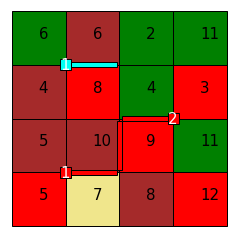

In [2]:
width, height = 4,4
dice = get_random_dice_arrangement(width, height)
resources = np.random.randint(0, 3, (height, width))
board = Catan(dice, resources, {6:0, 16:1}, {13:0}, {(6, 7):0, (7, 12):0, (12, 13):0, (16,17): 1})
board.register_player()
board.register_player()
board.draw()

In [3]:
def action(self):
    goal = determine_goal(board, self)
    
    if self.get_settlements() == []:
        (x,y) = optimal_settlement(board)
        self.buy("settlement", x, y) # we determined previously    
        print("bought settlement")                
    
    if goal == "settlement":
        (x, y) = optimal_settlement(board)
        if (x, y) in self.get_roads():
            if self.if_can_buy("settlement"):
                self.buy("settlement", x, y)
                print("bought settlement")                
        elif len(self.get_settlements()) > 0 and self.if_can_buy("road"):
            (v0, v1) = optimal_road(self)
            self.buy("road", v0, v1)
            print("bought road")
        #trade policy
        elif self.resources[np.argmax(self.resources)] >= 4:
            rmax, rmin = np.argmax(self.resources), np.argmin(self.resources)
            self.trade(rmax,rmin)

    elif goal == "city":
        if self.if_can_buy("city"):
            (x, y) = optimal_city(board)
            self.buy("city", x, y)
    elif goal == "card":
        if self.if_can_buy("card"):
            self.buy("card")
            print("bought card")   
        #trade policy
        elif self.resources[np.argmax(self.resources)] >= 4:
            rmax, rmin = np.argmax(self.resources), np.argmin(self.resources)
            self.trade(rmax,rmin)
            
    return

In [4]:
def determine_goal(board, self):
    buildings = ["settlement", "city", "card"]
    goal = "card"
    max_value = 0
    for building in buildings:
        time = hitting_time(board, building)
#         usefulness = determine_usefulness(board, building, self)
        usefulness = 0
        curr_value = 1/time + usefulness
        if curr_value > max_value:
            goal = building
            max_value = curr_value
    
    return goal

In [5]:
def hitting_time(board, building):
    if building == "settlement":
        return 5
    elif building == "card":
        return np.random.randint(1, 7)
    else:
        return 20

# def determine_usefulness(board, building, self):
    

In [6]:
def dumpPolicy(self, max_resources):
    new_resources = np.minimum(self.resources, max_resources // 3)
    return self.resources - new_resources

In [7]:
def planBoard(baseBoard):
    # prefer middle of the board over edges
    x = np.random.randint(1, baseBoard.width)
    y = np.random.randint(1, baseBoard.height)
    optSettlementLoc = (x,y)
    return optSettlementLoc

In [8]:
def optimal_road(self):
    goal_settlement
    curr_settlements = self.get_settlements()
    v1 = (settlements[0]//3, settlements[0] % 4)
    v2 = ((settlements[0]+1) //3, (settlements[0]+1) % 4)
    return (v1, v2)

In [9]:
def optimal_settlement(board):
    x = np.random.randint(1, board.width)
    y = np.random.randint(1, board.height)
    optSettlementLoc = (x,y)
    return optSettlementLoc
    

In [10]:
def optimal_city(board):
    x = np.random.randint(1, board.width)
    y = np.random.randint(1, board.height)
    optSettlementLoc = (x,y)
    return optSettlementLoc
    

In [11]:
# def tile_usefulness():
    

In [12]:
settlements, cities, roads, hands, live_points, dice_rolls = simulate_1p_game_with_data(action, dumpPolicy, planBoard, board)

def draw(t):
    t = int(t)
    live_board = Catan(board.dice, board.resources, [], [])
    live_board.settlements = settlements[t]
    live_board.cities = cities[t]
    live_board.roads = roads[t]
    print("turn:", t)
    print("points:", live_points[t])
    print("dice roll:", dice_rolls[t])
    print("resources:", hands[t])
    live_board.draw()

bought settlement
bought road
bought road
bought card
bought road
bought road
bought card
bought road
bought card
bought road
bought road
bought card
bought road
bought road
bought card
bought road
bought road
bought road
bought road
bought card
bought road
bought card
bought road
bought road
bought card
bought road
bought road
bought road
bought card


In [13]:
from ipywidgets import *
interact(draw, t=(0, len(live_points) - 1, 1))

interactive(children=(IntSlider(value=65, description='t', max=131), Output()), _dom_classes=('widget-interact…

<function __main__.draw(t)>

Drawing...
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


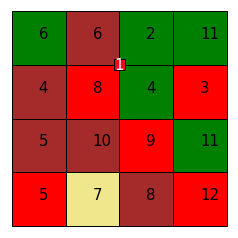

In [14]:
board.draw()
print(board.get_resources())

# wood is brown, brick is red, grain is green 
# below is the resource outcome of a dice roll 2-12

In [15]:
num_trials = 3

width, height = 4, 4
dice = get_random_dice_arrangement(width, height)
resources = np.random.randint(0, 3, (height, width))
board = Catan(dice, resources)
print("average turns to win: {}".format(simulate_1p_game(action, dumpPolicy, planBoard, board, num_trials)))

bought settlement
bought card
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought card
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought card
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought card
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought card
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought card
bought road
bought road
bought road
bought road
bought road
bought road
bought road
bought roa